<h1>PNEUMONIA DETECTION USING DEEP LEARNING </h1>

<h2>Download data from KAGGLE</h2>

[Dataset link](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

In [0]:
#installing data from kaggle
!pip install kaggle

In [0]:
#upload kaggle api .json file 
from google.colab import files
files.upload()

In [0]:
#making requirement for downloading data from kaggle 
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [0]:
#dataset link
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:30<00:00, 89.9MB/s]
100% 2.29G/2.29G [00:30<00:00, 79.8MB/s]


In [0]:
#unziping data 
!unzip /content/chest-xray-pneumonia.zip

<h2>VISUALIZEING DATA IN FOLDERS</h2>

In [0]:
#helper libraries
import os
import random 
import matplotlib.pyplot as plt
from glob import glob
import cv2

In [0]:
train_path = '/content/chest_xray/chest_xray/train' #path for tain set 
test_path = '/content/chest_xray/chest_xray/test' #path for test set

train_folder = glob('/content/chest_xray/train/*')
classes = len(train_folder)
print('Total number of classes :',classes)

Total number of classes : 2


Text(0.5, 1.0, 'PNEUMINIA')

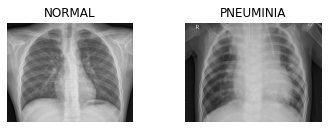

In [0]:
#reading two random images

img_0 = cv2.imread('/content/chest_xray/chest_xray/test/NORMAL/IM-0017-0001.jpeg')
img_1 = cv2.imread('/content/chest_xray/chest_xray/test/PNEUMONIA/person103_bacteria_488.jpeg')
plt.subplot(2,2,1)
plt.imshow(img_0, cmap='gray')
plt.axis('off')
plt.title('NORMAL')
plt.subplot(2,2,2)
plt.imshow(img_1,cmap='gray')
plt.axis('off')
plt.title('PNEUMINIA')

<h2>CREATING MODLE</h2>


<h3>Trying with VGG16 imagenet weights </h3>


In [0]:
# 1 vgg16 pretrained
#importing libraries

from tensorflow.keras.applications.vgg16 import VGG16 ,preprocess_input
from tensorflow.keras.layers import Input,Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential ,Model
import numpy as np

In [0]:
image_size = [224,224] #image size 

In [0]:
#downlading VGG16 imagenet weights
vgg_model = VGG16(input_shape=image_size+[3],weights='imagenet',include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [0]:
#using pretrained weights for VGG16
for layer in vgg_model.layers:
    layer.trainable = False

In [0]:
#tunning VGG16 last layers in model 
x = Flatten()(vgg_model.output)
pred = Dense(classes,activation='softmax')(x)
model = Model(inputs=vgg_model.input, outputs=pred)

In [0]:
#model architecture
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
#compiling model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
#train datagenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip = True)
#test datagenerator
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
#creating data datagenerator for training data
train_data = train_datagen.flow_from_directory(train_path,target_size = (224,224),batch_size = 32,class_mode = 'categorical')
#creating data datagenerator for testing data
test_data = test_datagen.flow_from_directory(test_path,target_size=(224,224),batch_size=32,class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


<p>traning model </p>

In [0]:
#traning model 
history = model.fit(
    train_data,
    validation_data = test_data,
    epochs = 10
)

Epoch 1/10
163/163 [==============================] - 101s 617ms/step - loss: 0.1874 - accuracy: 0.9296 - val_loss: 0.2813 - val_accuracy: 0.9071
Epoch 2/10
163/163 [==============================] - 101s 623ms/step - loss: 0.1085 - accuracy: 0.9565 - val_loss: 0.3639 - val_accuracy: 0.8942
Epoch 3/10
163/163 [==============================] - 102s 623ms/step - loss: 0.0958 - accuracy: 0.9643 - val_loss: 0.5589 - val_accuracy: 0.8478
Epoch 4/10
163/163 [==============================] - 101s 619ms/step - loss: 0.0966 - accuracy: 0.9636 - val_loss: 0.4180 - val_accuracy: 0.9022
Epoch 5/10
163/163 [==============================] - 102s 623ms/step - loss: 0.0701 - accuracy: 0.9745 - val_loss: 0.4741 - val_accuracy: 0.8910
Epoch 6/10
163/163 [==============================] - 101s 621ms/step - loss: 0.0666 - accuracy: 0.9751 - val_loss: 0.4860 - val_accuracy: 0.8702
Epoch 7/10
163/163 [==============================] - 102s 623ms/step - loss: 0.0704 - accuracy: 0.9747 - val_loss: 0.3718 -

In [0]:
#saving model
model.save('pneumonia.h5')

In [0]:
#creating validation data for evaluating model
val_path = '/content/chest_xray/chest_xray/val'
val_datagen = ImageDataGenerator(rescale=1./255)
val_data = val_datagen.flow_from_directory(val_path,target_size=(224,224),batch_size=32,class_mode='categorical')#evaluating model
loss,acc = model.evaluate(val_data)
print('Acc of model :',acc)
print('Loss of model :',loss)

Found 16 images belonging to 2 classes.
1/1 [==============================] - 0s 1ms/step - loss: 0.2833 - accuracy: 0.9375
Acc of model : 0.9375
Loss of model : 0.28329747915267944


In [0]:
classes_list = ['NORMAL','PNEUMONIA']
def predict(img_path):
    img = cv2.imread(img_path) #reading image
    img = cv2.resize(img,(224,224)) #resizing image 
    img = np.array(img).reshape(-1,224,224,3) #expanding dimensitions
    y_prob = model.predict(img) 
    c = y_prob.argmax()
    return classes_list[c]

In [0]:
#running our model on a PNEUMONIA image 
output = predict('/content/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg')
print('OUTPUT :',output)

OUTPUT : PNEUMONIA


In [0]:
#running our model on a NORMAL image 
output_ = predict('/content/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg')
print('OUTPUT :',output_)

OUTPUT : NORMAL
